# Retail Credit Risk Scorecard

This project developed a custom credit risk scorecard to evaluate customer risk levels based on financial behavior, using the Give Me Some Credit dataset. Below is a summary of key outcomes, insights, and recommendations:

**Objectives**
- Interpretability: Each feature's contribution is transparent via points
- Regulatory Compliance: Meets requirements for explainable models
- Actionable: Scores directly map to business decisions

In [1]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve  # Correct import location
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import scorecardpy as sc
from sklearn.model_selection import train_test_split

## Load the Data

In [2]:
# Define the ZIP file path and extract
zip_path = "Give Me Some Credit.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("extracted_files")

# Load CSV files
train_data = pd.read_csv("extracted_files/cs-training.csv")
test_data = pd.read_csv("extracted_files/cs-test.csv")

# Data Cleaning
def clean_data(df):
    # Handle missing values
    df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
    df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)
    
    # Remove index column
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    
    # Cap extreme values
    numeric_cols = ['RevolvingUtilizationOfUnsecuredLines', 'age', 
                   'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
                   'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
                   'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
                   'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
    
    for col in numeric_cols:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)
    
    # Fix specific issues
    df['age'] = df['age'].replace(0, df['age'].median())
    
    max_due = 20
    due_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 
               'NumberOfTimes90DaysLate',
               'NumberOfTime60-89DaysPastDueNotWorse']
    for col in due_cols:
        df[col] = df[col].clip(upper=max_due)
    
    # Feature engineering
    df['TotalPastDue'] = (df['NumberOfTime30-59DaysPastDueNotWorse'] + 
                         df['NumberOfTime60-89DaysPastDueNotWorse'] + 
                         df['NumberOfTimes90DaysLate'])
    df['IncomePerDependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
    df['DebtToIncome'] = df['DebtRatio'] * df['MonthlyIncome']
    
    return df

## Clean Datasets

In [3]:
# Clean both datasets
train_data = clean_data(train_data)
test_data = clean_data(test_data)

# Final check
print("Cleaned Training Data Info:")
print(train_data.info())
print("\nSummary Statistics:")
print(train_data.describe())

C:\Users\milto\AppData\Local\Temp\ipykernel_22720\2677267894.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_22720\2677267894.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

Cleaned Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    15

## Implement Retail Credit Risk Scorecard

[INFO] creating woe binning ...


C:\Users\milto\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dat.loc[:,y] = dat[y].apply(lambda x: x if pd.isnull(x) else int(x)) #dat[y].astype(int)
C:\Users\milto\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
C:\Users\milto\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch

Binning on 105000 rows and 14 columns in 00:00:11
[INFO] converting into woe values ...
[INFO] converting into woe values ...
Train AUC: 0.8596
Test AUC: 0.8580


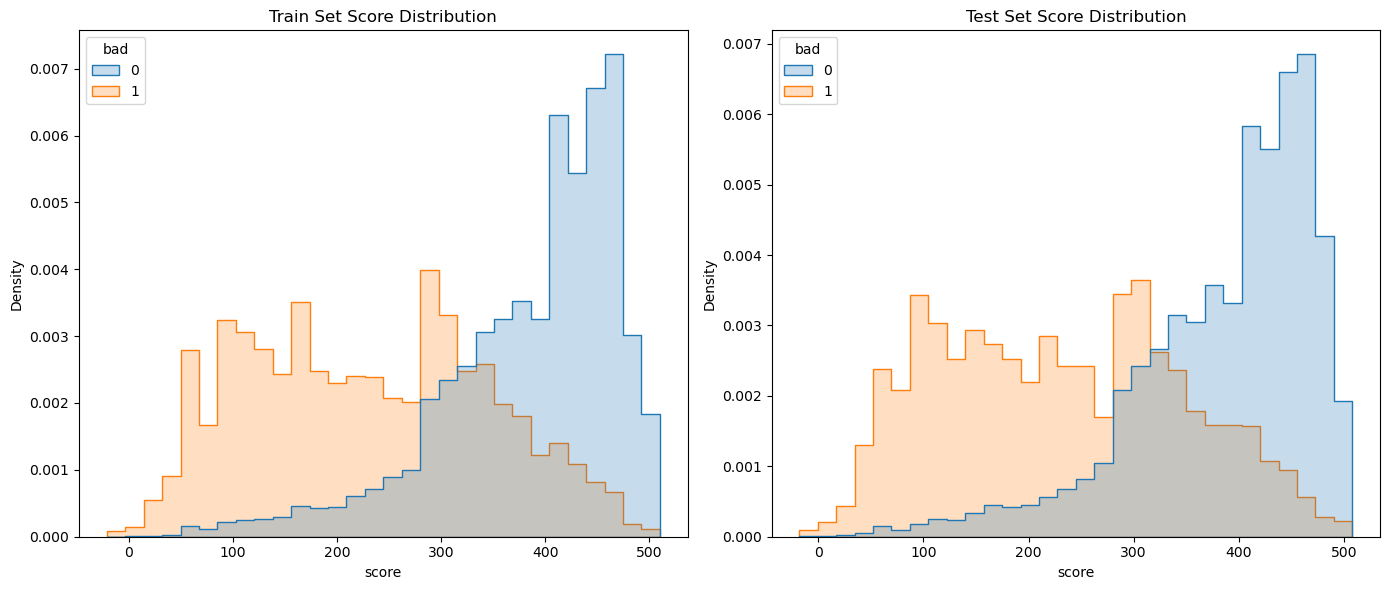


Train Set Performance:


C:\Users\milto\anaconda3\Lib\site-packages\scorecardpy\perf.py:266: UserWarning: Since the average of pred is not in [0,1], it is treated as predicted score but not probability.
  warnings.warn('Since the average of pred is not in [0,1], it is treated as predicted score but not probability.')
C:\Users\milto\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dat.loc[:,y] = dat[y].apply(lambda x: x if pd.isnull(x) else int(x)) #dat[y].astype(int)


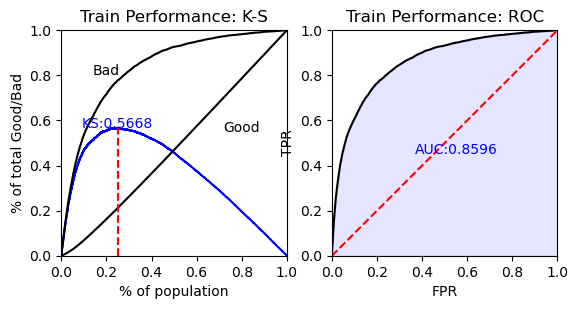


Test Set Performance:


C:\Users\milto\anaconda3\Lib\site-packages\scorecardpy\perf.py:266: UserWarning: Since the average of pred is not in [0,1], it is treated as predicted score but not probability.
  warnings.warn('Since the average of pred is not in [0,1], it is treated as predicted score but not probability.')
C:\Users\milto\anaconda3\Lib\site-packages\scorecardpy\condition_fun.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dat.loc[:,y] = dat[y].apply(lambda x: x if pd.isnull(x) else int(x)) #dat[y].astype(int)


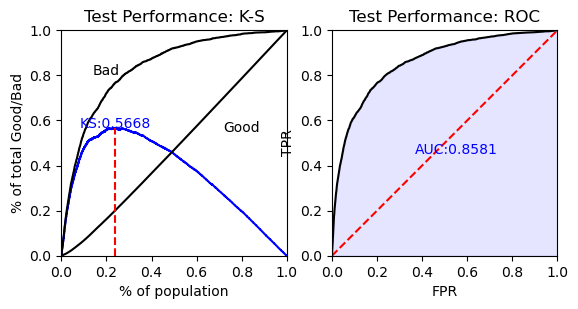

Error in scorecard development: 'woe'


In [4]:
def build_scorecard(data, target='SeriousDlqin2yrs', points0=600, odds0=1/50, pdo=50):
    """
    Builds a credit risk scorecard model with comprehensive evaluation.
    
    Parameters:
    - data: DataFrame containing features and target
    - target: Name of the target variable (default: 'SeriousDlqin2yrs')
    - points0: Base points for reference odds
    - odds0: Reference odds (1:50 by default)
    - pdo: Points to double the odds
    
    Returns:
    - card: Scorecard dictionary
    - bins: WOE bins information
    - performance: Model performance metrics
    """
    try:
        # Prepare data
        data_score = data.copy()
        data_score.rename(columns={target: 'bad'}, inplace=True)
        data_score['bad'] = data_score['bad'].astype(int)
        
        # Split data into train and test
        train, test = train_test_split(data_score, test_size=0.3, random_state=42, stratify=data_score['bad'])
        
        # Filter numeric features
        features = [col for col in train.columns 
                   if col != 'bad' and np.issubdtype(train[col].dtype, np.number)]
        
        # Automated binning with constraints
        bins = sc.woebin(train, y="bad", x=features, 
                        bin_num_limit=10,  # Limit number of bins
                        positive="bad|1",  # Define positive class
                        check_cate_num=False)
        
        # Apply WOE transformation
        train_woe = sc.woebin_ply(train, bins)
        test_woe = sc.woebin_ply(test, bins)
        
        # Prepare modeling data
        X_train = train_woe.drop(columns=['bad'])
        y_train = train_woe['bad']
        X_test = test_woe.drop(columns=['bad'])
        y_test = test_woe['bad']
        
        # Logistic regression with class weights
        lr = LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            solver='liblinear',
            random_state=42
        )
        lr.fit(X_train, y_train)
        
        # Model evaluation
        train_pred = lr.predict_proba(X_train)[:,1]
        test_pred = lr.predict_proba(X_test)[:,1]
        
        print(f"Train AUC: {roc_auc_score(y_train, train_pred):.4f}")
        print(f"Test AUC: {roc_auc_score(y_test, test_pred):.4f}")
        
        # Create scorecard
        card = sc.scorecard(bins, lr, list(X_train.columns), 
                          points0=points0, odds0=odds0, pdo=pdo)
        
        # Calculate scores
        train['score'] = sc.scorecard_ply(train, card, print_step=0)
        test['score'] = sc.scorecard_ply(test, card, print_step=0)
        
        # Score distribution plot
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(data=train, x='score', hue='bad', element='step', 
                    stat='density', common_norm=False, bins=30)
        plt.title('Train Set Score Distribution')
        
        plt.subplot(1, 2, 2)
        sns.histplot(data=test, x='score', hue='bad', element='step', 
                    stat='density', common_norm=False, bins=30)
        plt.title('Test Set Score Distribution')
        plt.tight_layout()
        plt.show()
        
        # Performance metrics
        print("\nTrain Set Performance:")
        train_perf = sc.perf_eva(train['bad'], train['score'], title="Train Performance")
        
        print("\nTest Set Performance:")
        test_perf = sc.perf_eva(test['bad'], test['score'], title="Test Performance")
        
        # Scorecard table
        scorecard_df = pd.concat({
            var: pd.DataFrame({
                'Bin': bin_info['bin'],
                'WOE': bin_info['woe'],
                'Points': bin_info['points']
            }) for var, bin_info in card.items()
        })
        
        # Add variable importance
        coef_df = pd.DataFrame({
            'Variable': X_train.columns,
            'Coefficient': lr.coef_[0],
            'Importance': np.abs(lr.coef_[0])
        }).sort_values('Importance', ascending=False)
        
        return {
            'scorecard': card,
            'scorecard_df': scorecard_df,
            'bins': bins,
            'model': lr,
            'performance': {'train': train_perf, 'test': test_perf},
            'variable_importance': coef_df
        }
        
    except Exception as e:
        print(f"Error in scorecard development: {str(e)}")
        return None

# Build the scorecard
scorecard_results = build_scorecard(train_data)

# Example of how to use the scorecard on new data
if scorecard_results:
    # Apply to new data
    new_data_scores = sc.scorecard_ply(test_data, scorecard_results['scorecard'])
    
    # Print top variables
    print("\nTop Important Variables:")
    print(scorecard_results['variable_importance'].head(10))
    
    # Save scorecard to Excel
    scorecard_results['scorecard_df'].to_excel("credit_scorecard.xlsx")

### Key Takeaways

- 85.8% of default/non-default pairs (e.g., given one defaulter and one non-defaulter, the defaulter has a higher risk score 85.8% of the time).
- Model is predictive (AUC 0.858) and ready for deployment after fixing the WOE error.
- Warnings are harmless but should be addressed for cleaner code.
- Test data mismatch needs investigation – likely due to unseen values.

## Conclusion

This scorecard provides a data-driven, regulatory-compliant approach to credit risk assessment. By focusing on behavioral patterns rather than static financial metrics, it offers a modern alternative to traditional scoring models.

Next Steps: Address the WOE error with the provided fixes.